10
20
30
40
50
60
70
80
90
100


,Event,Light,RTC,Temp,Day,Month,Minutes
0,0.0,579.0,2022-12-01 10:40:00,24.0,3,12,640
1,0.0,639.0,2022-12-01 12:40:00,20.7,3,12,760
2,0.0,601.0,2022-12-01 15:50:00,23.0,3,12,950
3,0.0,492.0,2022-12-01 18:20:00,20.8,3,12,1100
4,1.0,493.0,2022-12-01 19:00:00,21.4,3,12,1140
...,...,...,...,...,...,...,...
408,0.0,526.0,2022-12-27 11:30:00,19.8,1,12,690
409,0.0,535.0,2022-12-27 12:20:00,20.4,1,12,740
410,1.0,496.0,2022-12-27 18:40:00,20.0,1,12,1120
411,0.0,608.0,2022-12-27 20:10:00,22.3,1,12,1210


Accuracy: 0.891566265060241
Accuracy: 74%
10
20


KeyboardInterrupt: 

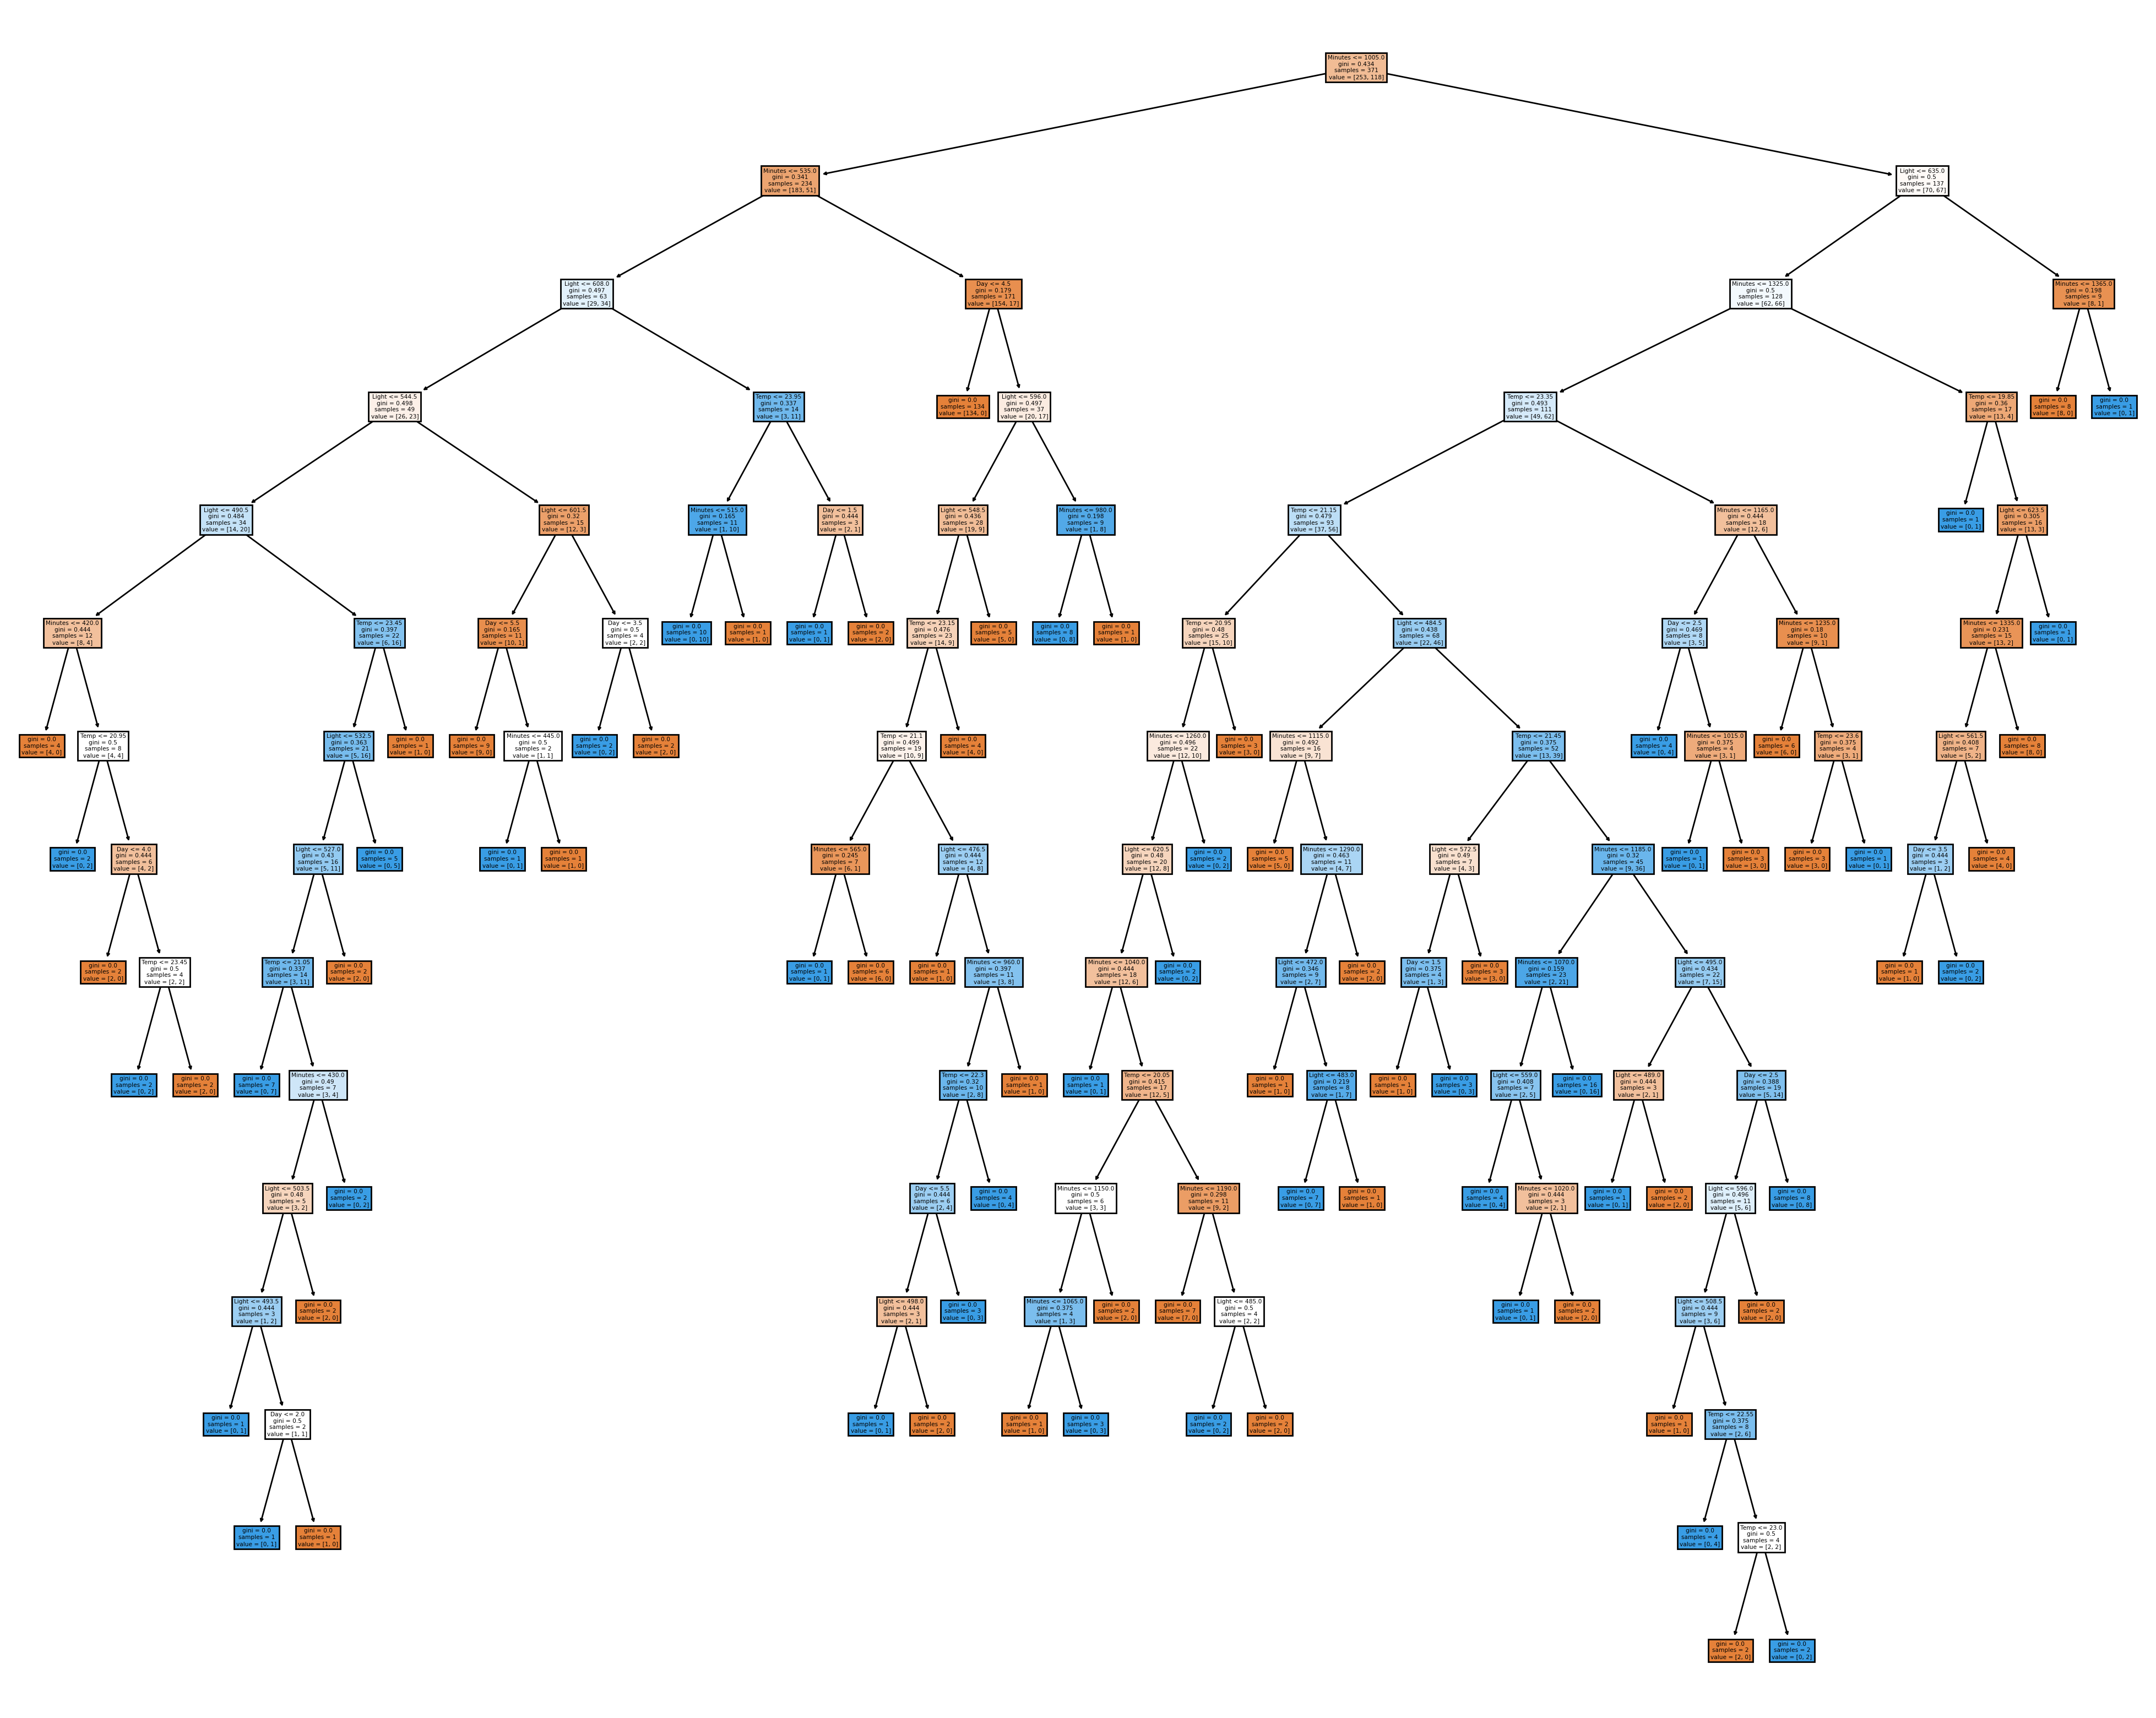

In [10]:
import time
import pandas as pd
from datetime import datetime
import joblib
import os.path
import matplotlib.pyplot as plt

#Firebase Libraries
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db

#Machine Leearning Libraries
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets

#Fetch the service account key JSON file contents
cred = credentials.Certificate("serviceAccountKey.json")

#initialize the app if not already
if not firebase_admin._apps:
    firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://smartyblinds-default-rtdb.firebaseio.com/'
    })
    
SERIAL_NUM = 123

week_min = 0

#Run infinitely 
while(1):

    #Repeat every 10 minutes
    #time.sleep(10*60)
    time.sleep(1)
    
    week_min = week_min + 10
    
    print(week_min)

    #Store sensor data from firebase & Train with the dataframe 
    #only if we have at least 50 data points
    #and if the current week is different than the most recent data point week
    #(collect and train every week)

    ref_total_data = db.reference('Blinds/' + str(SERIAL_NUM) + '/Total_Data')
    total_data = int(ref_total_data.get())

    ref_event = db.reference('Blinds/' + str(SERIAL_NUM) + '/Data/' + str(total_data) + '/RTC')
    recent = ref_event.get()
    recent_week = datetime.strptime(str(recent), "%Y-%m-%d %H:%M:%S")

    today_week = datetime.today()
    #print("Today date is: ", recent_week.isocalendar().week)
    #print("Today date is: ", today_week.isocalendar().week)
    #print("Today date is: ", (today_week.isocalendar().week)!=(recent_week.isocalendar().week))

    if ((total_data >= 50) and ((today_week.isocalendar()[1])!=(recent_week.isocalendar()[1]+3)) and (week_min == 100) ):

        dictionary = {"Event":[],"Light":[],"RTC":[],"Temp":[]}

        for i in range(total_data):
            ref_event = db.reference('Blinds/' + str(SERIAL_NUM) + '/Data/' + str(i + 1) + '/Event')
            event = ref_event.get()
            dictionary['Event'].append(event)

            ref_event = db.reference('Blinds/' + str(SERIAL_NUM) + '/Data/' + str(i + 1) + '/Light')
            event = ref_event.get()
            dictionary['Light'].append(event)

            ref_event = db.reference('Blinds/' + str(SERIAL_NUM) + '/Data/' + str(i + 1) + '/RTC')
            event = ref_event.get()
            dateOBJ = datetime.strptime(str(event), "%Y-%m-%d %H:%M:%S")
            dictionary['RTC'].append(dateOBJ)

            ref_event = db.reference('Blinds/' + str(SERIAL_NUM) + '/Data/' + str(i + 1) + '/Temp')
            event = ref_event.get()
            dictionary['Temp'].append(event)

        #Saved sensor information into dataframe.
        df = pd.DataFrame(dictionary)

        #Convert into readable dataframe for ML algorithm
        df['Day'] = df['RTC'].dt.dayofweek
        df['Month'] = df['RTC'].dt.month
        df['Minutes'] = ((df['RTC'].dt.hour * 60) + df['RTC'].dt.minute)

        display(df)

        #Save data from firebase onto local server csv
        #df.to_csv('Data_' + str(SERIAL_NUM),index = False)

        #Retrieve saved data from local server csv
        #df = pd.read_csv('data')




        #Training with the dataframe 

        #Initialize variables for the final decision tree parameters
        crit = 0
        max_split = 0
        max_rand = 0
        max_leaf = 0
        max_deep = 0
        max_accuracy = 0
        
        #Split dataset in features and target variable
        conditions = ['Light', 'Temp', 'Day', 'Minutes']
        X = df[conditions].values
        y = df.Event
        
        #Nested for loop used to cycle through multiple different parameters to determine the best results
        for i in range(2, 4):
            for j in range(0, 43):
                for k in range(0, 2):
                    for l in range(2, 200):
                        for m in range(1, 20):

                            #Splits the data into a training set and testing set
                            x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=(i/10), random_state=j, shuffle=True)

                            #If statement which checks if the criterion used for the tree should be 'gini' or 'entropy'
                            if k == 0:
                                testtree = DecisionTreeClassifier(criterion="gini", max_leaf_nodes=l, max_depth=m, splitter="best")
                            elif k == 1:
                                testtree = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=l, max_depth=m, splitter="best")

                            #Fits the data into a decision tree
                            testtree.fit(x_train, y_train)

                            #Prediction gives the accuracy of the decision tree based on the testing data
                            prediction = testtree.predict(x_test)
                            accuracy = metrics.accuracy_score(y_test, prediction)
                

                            #If statement which saves the values of the parameters which gives the highest accuracy into variables
                            if accuracy > max_accuracy:
                                max_accuracy = accuracy
                                max_split = i/10
                                max_rand = j
                                max_leaf = l
                                max_deep = m

                                if k == 0:
                                    crit = 0
                                elif k == 1:
                                    crit = 1

        #Prints out the highest accuracy possible for this data set
        print("Accuracy:", max_accuracy)

        #Split dataset into training set and test set 
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

        #Creates a decision tree using the paramters which gave the highest accuracy
        if crit == 0:
            dtree = DecisionTreeClassifier(criterion="gini", max_leaf_nodes=max_leaf, max_depth=max_deep, splitter="best")
        elif crit == 1:
            dtree = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=max_leaf, max_depth=max_deep, splitter="best")
            
        #Create Decision Tree classifer object
        dtree = DecisionTreeClassifier()

        #Train Decision Tree Classifer
        dtree = dtree.fit(x_train,y_train)

        #save the model
        joblib.dump(dtree, 'Tree_Model_'+ str(SERIAL_NUM) +'.sav')

        #Predict the response for test dataset
        y_pred = dtree.predict(x_test)
        #Model Accuracy, how often is the classifier correct?
        print("Accuracy:",str(round(metrics.accuracy_score(y_test, y_pred)*100)) + "%")
        #Visualizing Decision Trees
        fig = plt.figure(figsize=(25,20), dpi=200)
        tree.plot_tree(dtree, feature_names=conditions, filled=True)
        
        
        week_min = 0

## Train from csv

Accuracy: 0.8823529411764706
Accuracy: 65%


[Text(0.4923780487804878, 0.96875, 'Temp <= 22.85\ngini = 0.441\nsamples = 152\nvalue = [102, 50]'),
 Text(0.21646341463414634, 0.90625, 'Minutes <= 560.0\ngini = 0.5\nsamples = 70\nvalue = [35, 35]'),
 Text(0.04878048780487805, 0.84375, 'Temp <= 20.1\ngini = 0.305\nsamples = 16\nvalue = [3, 13]'),
 Text(0.024390243902439025, 0.78125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.07317073170731707, 0.78125, 'Day <= 4.5\ngini = 0.231\nsamples = 15\nvalue = [2, 13]'),
 Text(0.04878048780487805, 0.71875, 'gini = 0.0\nsamples = 8\nvalue = [0, 8]'),
 Text(0.0975609756097561, 0.71875, 'Temp <= 21.25\ngini = 0.408\nsamples = 7\nvalue = [2, 5]'),
 Text(0.07317073170731707, 0.65625, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.12195121951219512, 0.65625, 'Temp <= 22.25\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.0975609756097561, 0.59375, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.14634146341463414, 0.59375, 'Day <= 5.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),

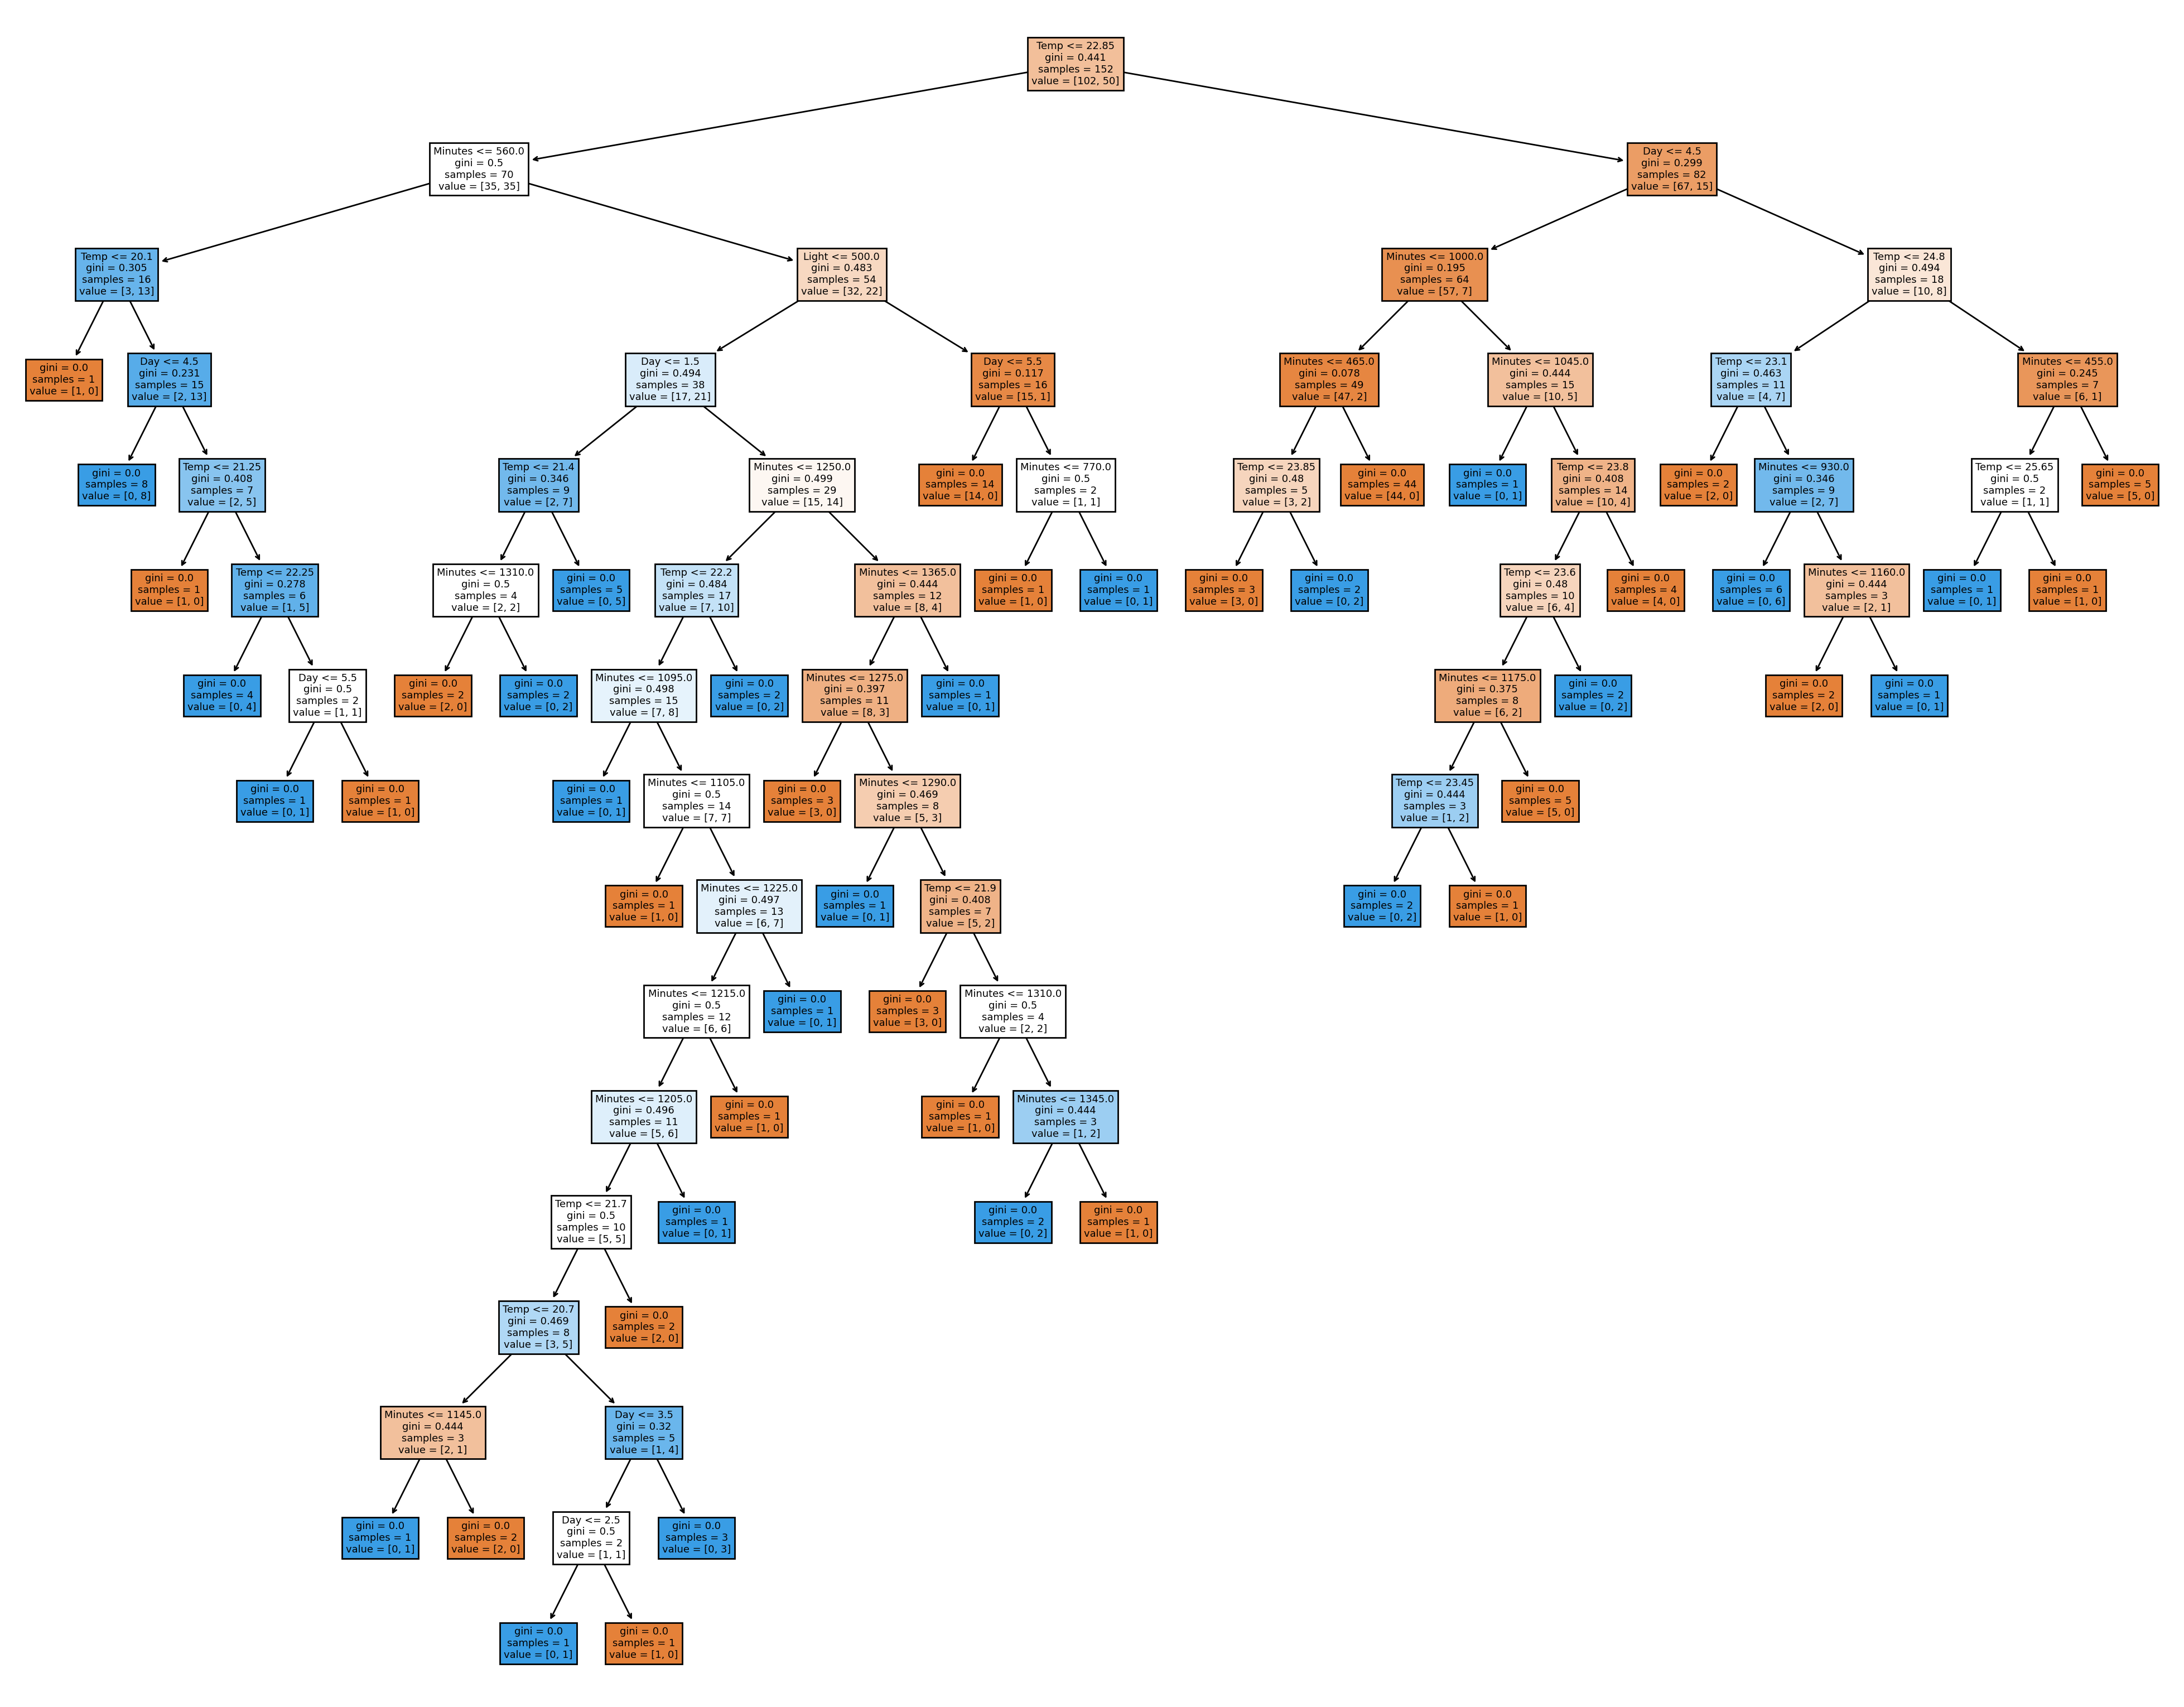

In [3]:
import time
import pandas as pd
from datetime import datetime
import joblib
import os.path
import matplotlib.pyplot as plt

#Firebase Libraries
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db

#Machine Leearning Libraries
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets




df = pd.read_csv('Light.csv')




#Training with the dataframe 

#Initialize variables for the final decision tree parameters
crit = 0
max_split = 0
max_rand = 0
max_leaf = 0
max_deep = 0
max_accuracy = 0

#Split dataset in features and target variable
conditions = ['Light', 'Temp', 'Day', 'Minutes']
X = df[conditions].values
y = df.Event

#Nested for loop used to cycle through multiple different parameters to determine the best results
for i in range(2, 4):
    for j in range(0, 43):
        for k in range(0, 2):
            for l in range(2, 200):
                for m in range(1, 20):

                    #Splits the data into a training set and testing set
                    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=(i/10), random_state=j, shuffle=True)

                    #If statement which checks if the criterion used for the tree should be 'gini' or 'entropy'
                    if k == 0:
                        testtree = DecisionTreeClassifier(criterion="gini", max_leaf_nodes=l, max_depth=m, splitter="best")
                    elif k == 1:
                        testtree = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=l, max_depth=m, splitter="best")

                    #Fits the data into a decision tree
                    testtree.fit(x_train, y_train)

                    #Prediction gives the accuracy of the decision tree based on the testing data
                    prediction = testtree.predict(x_test)
                    accuracy = metrics.accuracy_score(y_test, prediction)


                    #If statement which saves the values of the parameters which gives the highest accuracy into variables
                    if accuracy > max_accuracy:
                        max_accuracy = accuracy
                        max_split = i/10
                        max_rand = j
                        max_leaf = l
                        max_deep = m

                        if k == 0:
                            crit = 0
                        elif k == 1:
                            crit = 1

#Prints out the highest accuracy possible for this data set
print("Accuracy:", max_accuracy)

#Split dataset into training set and test set 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

#Creates a decision tree using the paramters which gave the highest accuracy
if crit == 0:
    dtree = DecisionTreeClassifier(criterion="gini", max_leaf_nodes=max_leaf, max_depth=max_deep, splitter="best")
elif crit == 1:
    dtree = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=max_leaf, max_depth=max_deep, splitter="best")

#Create Decision Tree classifer object
dtree = DecisionTreeClassifier()

#Train Decision Tree Classifer
dtree = dtree.fit(x_train,y_train)

#save the model
joblib.dump(dtree, 'Time.sav')

#Predict the response for test dataset
y_pred = dtree.predict(x_test)
#Model Accuracy, how often is the classifier correct?
print("Accuracy:",str(round(metrics.accuracy_score(y_test, y_pred)*100)) + "%")
#Visualizing Decision Trees
fig = plt.figure(figsize=(25,20), dpi=200)
tree.plot_tree(dtree, feature_names=conditions, filled=True)